## Project - Pneumonia Detection


**CONTEXT:**

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation
of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical
images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

**DATA DESCRIPTION:**

- In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was
determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the
appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original link to the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data [ for your reference
only ]. You can refer to the details of the dataset in the above link
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

**DATASET:**

The dataset contains the following files and folders:

- stage_2_train_labels.csv - The training set. It contains patientIds and bounding box / target information.
- stage_2_detailed_class_info.csv – It provides detailed information about the type of positive or negative class for each image.

Apart from the above-mentioned data files (in csv format), the dataset also contains the images folders

- stage_2_train_images
- stage_2_test_images

The images in the above-mentioned folders are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.


## Objective

Milestone 1:
The objective of this notebook is to do Pre-Processing, Data Visualization and EDA.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.9 MB/s eta 0:00:00


#### Import Packages

In [ ]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dcm
import os
from glob import glob
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
import os
from matplotlib.patches import Rectangle

#### Preparation of Train Dataset

#### Reading CSV files

In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/datasets/stage_2_train_labels.csv')
print('First five rows of Training set:\n', train_labels.head())

First five rows of Training set:
                               patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Some information about the data field present in the 'stage_2_train_labels.csv' are:
*   **patientId** - A patientId.
*   **x** - The x coordinate of the bounding box
*   **y** - The y coordinate of the bounding box
*   **width** - The width of the bounding box
*   **height** - The height of the bounding box
*   **Target** - The binary Target indicating whether this sample has evidence of pneumonia or not.




In [ ]:
# Number of entries in Train label dataframe:
print('The train_label dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))

The train_label dataframe has 30227 rows and 6 columns.


In [ ]:
# Number of duplicates in patientId:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

Number of unique patientId are: 26684


Thus, the dataset contains information about 26684 patients. Out of these 26684 patients, some of them have multiple entries in the dataset.

In [ ]:
print(f'No of entries which has Pneumonia: {train_labels[train_labels.Target == 1].shape[0]} ~ {round(train_labels[train_labels.Target == 1].shape[0]/train_labels.shape[0]*100, 0)}%')
print(f'No of entries which don\'t have Pneumonia: {train_labels[train_labels.Target == 0].shape[0]} ~ {round(train_labels[train_labels.Target == 0].shape[0]/train_labels.shape[0]*100, 0)}%')
_ = train_labels['Target'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Negative', 'Positive'], figsize = (6, 6))

No of entries which has Pneumonia: 9555 ~ 32.0%
No of entries which don't have Pneumonia: 20672 ~ 68.0%


Thus, from the above pie chart it is clear that out of 30227 entries in the dataset, there are 20672 (i.e., 68%) entries in the dataset which corresponds to the entries of the patient Not having Pnuemonia whereas 9555 (i.e., 32%) entries corresponds to Positive case of Pneumonia.

In [ ]:
# Checking nulls in bounding box columns:
print('Number of nulls in bounding box columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))

Number of nulls in bounding box columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}


Thus, we can see that number of nulls in bounding box columns are equal to the number of 0's we have in the Target column.

Thus, there are 23286 unique patients which have only one entry in the dataset and so on.


- **stage_2_detailed_class_info.csv**

It provides detailed information about the type of positive or negative class for each image.


In [ ]:
class_labels = pd.read_csv('/content/drive/MyDrive/datasets/stage_2_detailed_class_info.csv')
print('First five rows of Class label dataset are:\n', class_labels.head())

First five rows of Class label dataset are:
                               patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


Some information about the data field present in the 'stage_2_detailed_class_info.csv' are:
*   **patientId** - A patientId.
*   **class** - Have three values depending what is the current state of the patient's lung: 'No Lung Opacity / Not Normal', 'Normal' and 'Lung Opacity'.



In [ ]:
# Number of entries in class_label dataframe:
print('The class_label dataframe has {} rows and {} columns.'.format(class_labels.shape[0], class_labels.shape[1]))

The class_label dataframe has 30227 rows and 2 columns.


In [ ]:
# Number of duplicates in patients:
print('Number of unique patientId are: {}'.format(class_labels['patientId'].nunique()))

Number of unique patientId are: 26684


Thus, the dataset contains information about 26684 patients (which is same as that of the train_labels dataframe).



In [ ]:
def get_feature_distribution(data, feature):
  # Count for each label
  label_counts = data[feature].value_counts()
  # Count the number of items in each class
  total_samples = len(data)
  print("Feature: {}".format(feature))
  for i in range(len(label_counts)):
    label = label_counts.index[i]
    count = label_counts.values[i]
    percent = int((count / total_samples) * 10000) / 100
    print("{:<30s}: {} which is {}% of the total data in the dataset".format(label, count, percent))

In [ ]:
get_feature_distribution(class_labels, 'class')

Feature: class
No Lung Opacity / Not Normal  : 11821 which is 39.1% of the total data in the dataset
Lung Opacity                  : 9555 which is 31.61% of the total data in the dataset
Normal                        : 8851 which is 29.28% of the total data in the dataset


In [ ]:
class_counts = class_labels['class'].value_counts().sort_index(ascending=False)
class_percentages = (class_counts / class_counts.sum()) * 100

# Plot the bar graph
fig, ax = plt.subplots(figsize=(5, 5))
class_percentages.plot(kind='bar', ax=ax)
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Class')
ax.set_title('Class Distribution in Percentage')
ax.bar_label(ax.containers[0], fmt='%.0f%%')  # Adding percentage labels on bars
plt.show()

In [ ]:
# Checking nulls in class_labels:
print('Number of nulls in class columns: {}'.format(class_labels['class'].isnull().sum()))

Number of nulls in class columns: 0


Thus, none of the columns in class_labels has an empty row.

In [ ]:
# Checking whether each patientId has only one type of class or not
class_labels.groupby(['patientId'])['class'].nunique().max()

1

Thus, we can say that each patientId is associated with only 1 class.

In [ ]:
# Merging the two dataset - 'train_labels' and 'class_labels':
training_data = pd.concat([train_labels, class_labels['class']], axis = 1)
print('After merging, the dataset looks like: \n')
training_data.head()

After merging, the dataset looks like: 



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  
0                1  No Lung Opacity / Not Normal  
1                1  No Lung Opacity / Not Normal  
2                1  No Lung Opacity / Not Normal  
3                1                        Normal  
4                2                  Lung Opacity

In [ ]:
print('After merge, the dataset has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))

After merge, the dataset has 30227 rows and 8 columns.


#### Target and Class

Text(0.5, 1.0, 'Class and Target for Chest Exams')

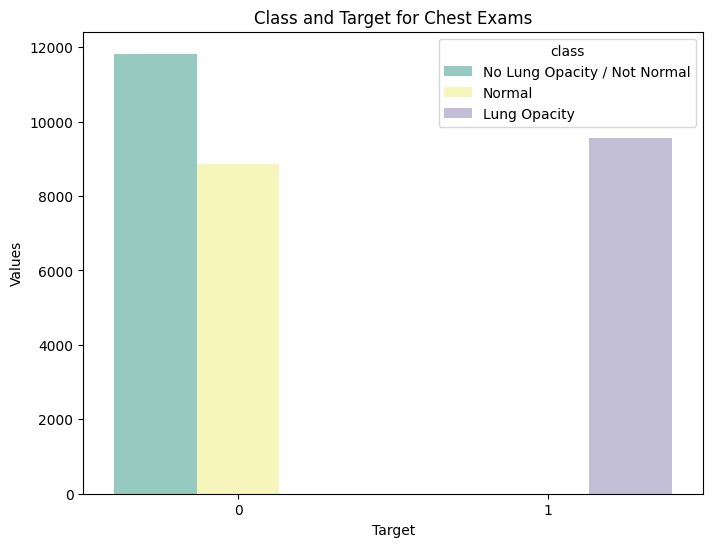

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (8, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target for Chest Exams')

Thus, **Target = 1** is associated with only **class = Lung Opacity** whereas **Target = 0** is associated with only **class = No Lung Opacity / Not Normal** as well as **Normal**.

#### Bounding Box Distribution

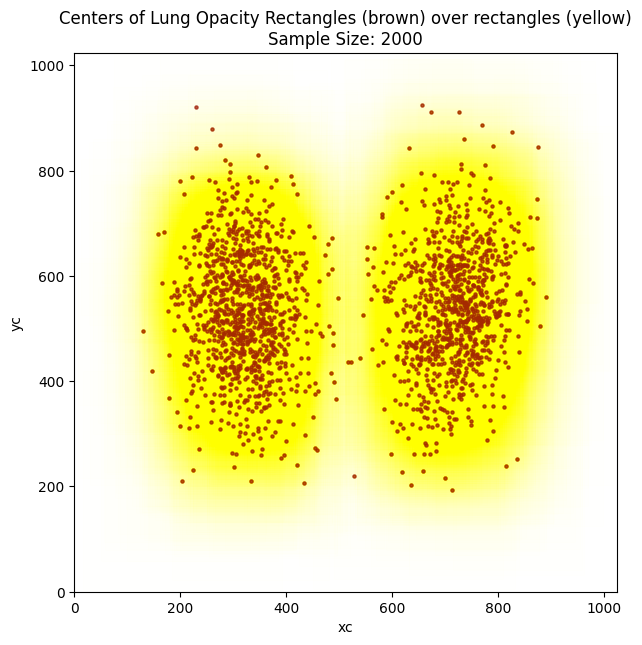

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
target_1 = training_data[training_data['Target'] == 1]
target_sample = target_1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title('Centers of Lung Opacity Rectangles (brown) over rectangles (yellow)\nSample Size: 2000')
target_sample.plot.scatter(x = 'xc', y = 'yc', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = '.', color = 'brown')

for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))

Thus, we can see that the centers for the bounding box are spread out evenly across the Lungs. Though a large portion of the bounding box have their centers at the centers of the Lung, but some centers of the box are also located at the edges of lung.

#### Reading Images

Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [ ]:
# Create a ZipFile Object and load sample.zip in it
def extract_zipFile(source_path,destination_path):
  try:
    with ZipFile(source_path, 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall(destination_path)
  except Exception as e:
    print(str(e))

In [ ]:
#extracting train images
extract_zipFile('/content/drive/MyDrive/datasets/stage_2_train_images.zip','/content/drive/MyDrive/zipOut/')
extract_zipFile('/content/drive/MyDrive/datasets/stage_2_test_images.zip','/content/drive/MyDrive/zipOut/')

In [ ]:
sample_patientId = train_labels['patientId'][0]
dcm_file = '/content/drive/MyDrive/zipOut/stage_2_train_images/'+'{}.dcm'.format(sample_patientId)
dcm_data = dcm.read_file(dcm_file)

print('Metadata of the image consists of \n', dcm_data)

Metadata of the image consists of 
 Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '190

From the above sample we can see that dicom file contains some of the information that can be used for further analysis such as sex, age, body part examined, view position and modality. Size of this image is 1024 x 1024 (rows x columns).

In [ ]:
print('Number of images in training images folders are: {}.'.format(len(os.listdir('/content/drive/MyDrive/zipOut/stage_2_train_images'))))

Number of images in training images folders are: 26684.


Thus, we can see that in the training images folder we have just 26684 images which is same as that of unique patientId's present in either of the csv files. Thus, we can say that **each of the unique patientId's present in either of the csv files corresponds to an image present in the folder**.

In [ ]:
training_image_path = '/content/drive/MyDrive/zipOut/stage_2_train_images'

images = pd.DataFrame({'path': glob(os.path.join(training_image_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images dataframe: {}'.format(list(images.columns)))

Columns in the training images dataframe: ['path', 'patientId']


In [ ]:
# Merging the images dataframe with training_data dataframe
training_data = training_data.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the training_data has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))

After merging the two dataframe, the training_data has 30227 rows and 9 columns.


In [ ]:
print('The training_data dataframe as of now - \n')
training_data.head()

The training_data dataframe as of now - 



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path  
0  /content/drive/MyDrive/zipOut/stage_2_train_im...  
1  /content/drive/MyDrive/zipOut/stage_2_train_im...  
2  /content/drive/MyDrive/zipOut/stage_2_train_im...  
3  /content/drive/MyDrive/zipOut/stage_2_train_im...  
4  /content/drive/MyDrive/zipOut/stage_2_train_im...

In [ ]:
from tqdm import tqdm, tqdm_notebook

columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def parse_dicom_data(data_df, data_path):
  for col in columns_to_add:
    data_df[col] = None
  image_names = os.listdir('/content/drive/MyDrive/zipOut/stage_2_train_images')

  for i, img_name in tqdm_notebook(enumerate(image_names)):
    imagepath = os.path.join('/content/drive/MyDrive/zipOut/stage_2_train_images', img_name)
    data_img = dcm.read_file(imagepath)
    idx = (data_df['patientId'] == data_img.PatientID)
    data_df.loc[idx, 'Modality'] = data_img.Modality
    data_df.loc[idx, 'PatientAge'] = pd.to_numeric(data_img.PatientAge)
    data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
    data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
    data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition
    data_df.loc[idx, 'ConversionType'] = data_img.ConversionType
    data_df.loc[idx, 'Rows'] = data_img.Rows
    data_df.loc[idx, 'Columns'] = data_img.Columns
    data_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", data_img.PixelSpacing[0])

In [ ]:
parse_dicom_data(training_data, '/content/drive/MyDrive/zipOut/stage_2_train_images/')

0it [00:00, ?it/s]

In [ ]:
print('So after parsing the information from the dicom images, our training_data dataframe has {} rows and {} columns and it looks like:\n'.format(training_data.shape[0], training_data.shape[1]))
training_data.head()

So after parsing the information from the dicom images, our training_data dataframe has 30227 rows and 18 columns and it looks like:



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         51   
1  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         48   
2  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         19   
3  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         28   
4  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing  
0        0.143  
1        0.194  
2        0.168  
3        0.143  
4        0.139

In [ ]:
# Saving the training_data for further use:
training_data.to_pickle('training_data.pkl')

Going forward we will now use this pickle file as our training data.

EDA on this saved training data:

In [ ]:
training_data = pd.read_pickle('training_data.pkl')
print(f'Our training data consists of {training_data.shape[0]} rows and {training_data.shape[1]} columns and looks like as: \n')
training_data.head()

Our training data consists of 30227 rows and 18 columns and looks like as: 



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         51   
1  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         48   
2  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         19   
3  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         28   
4  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing  
0        0.143  
1        0.194  
2        0.168  
3        0.143  
4        0.139

#### Modality

In [ ]:
print('Modality for the images obtained is: {} \n'.format(training_data['Modality'].unique()[0]))

Modality for the images obtained is: CR 



#### Body Part Examined

In [ ]:
print('The images obtained are of {} areas.'.format(training_data['BodyPartExamined'].unique()[0]))

The images obtained are of CHEST areas.


#### Understanding Different Positions

In [ ]:
get_feature_distribution(training_data, 'ViewPosition')

Feature: ViewPosition
AP                            : 15297 which is 50.6% of the total data in the dataset
PA                            : 14930 which is 49.39% of the total data in the dataset


As seen above, two View Positions that are in the training dataset are AP (Anterior/Posterior) and PA (Posterior/Anterior). These type of X-rays are mostly used to obtain the front-view. Apart from front-view, a lateral image is usually taken to complement the front-view.
- **Posterior/Anterior (PA)**: Here the chest radiograph is acquired by passing the X-Ray beam from the patient's posterior (back) part of the chest  to the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film. In this image, the hear is on the right side of the image as one looks at it. These are of higher quality and assess the heart size more accurately
- **Anterior/Posterior (AP)**: At times it is not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. In these images the size of Heart is exaggerated.

The distribution of View Position when there is an evidence of Pneumonia:



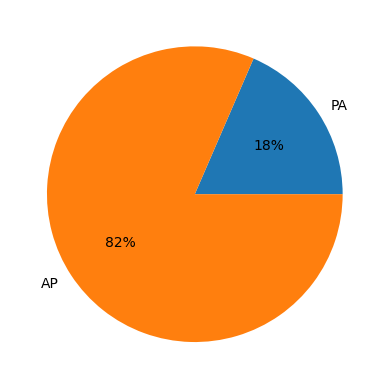

In [ ]:
print('The distribution of View Position when there is an evidence of Pneumonia:\n')
_ = training_data.loc[training_data['Target'] == 1, 'ViewPosition'].value_counts().sort_index(ascending = False).plot(kind = 'pie', autopct = '%.0f%%').set_ylabel('')

Plot x and y centers of bounding box


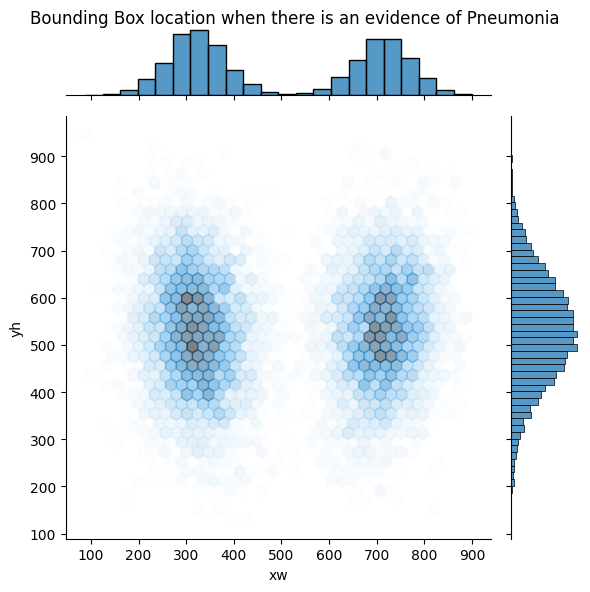

In [ ]:
import matplotlib.pyplot as plt

print('Plot x and y centers of bounding box')
bboxes = training_data[training_data['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x=bboxes['xw'], y=bboxes['yh'], data=bboxes, kind='hex', alpha=0.5)
plt.suptitle('Bounding Box location when there is an evidence of Pneumonia')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

In [ ]:
def bboxes_scatter(data, color_point, color_window, text):
  fig, ax = plt.subplots(1, 1, figsize = (7, 7))
  plt.title('Plotting centers of Lung Opacity\n{}'.format(text))
  data.plot.scatter(x = 'xw', y = 'yh', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = ".", color = color_point)
  for i, crt_sample in data.iterrows():
    ax.add_patch(Rectangle(xy = (crt_sample['x'], crt_sample['y']), width = crt_sample['width'], height = crt_sample['height'], alpha = 3.5e-3, color = color_window))

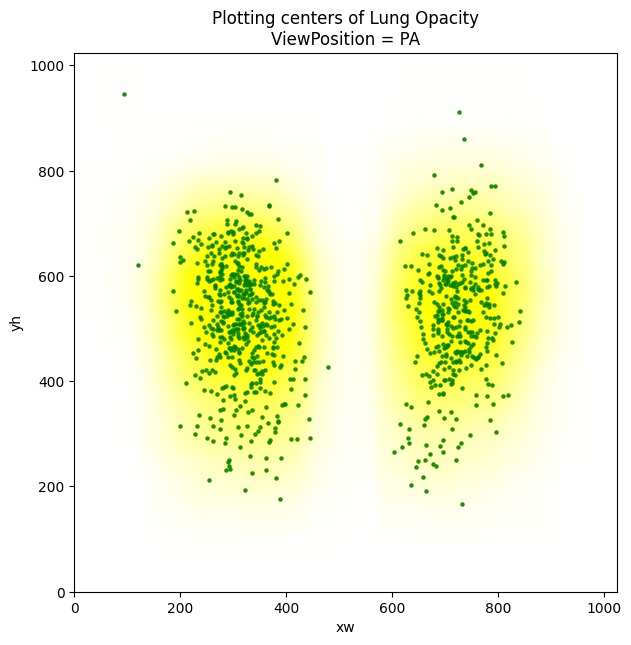

In [ ]:
data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)

bboxes_scatter(data_PA, 'green', 'yellow', 'ViewPosition = PA')

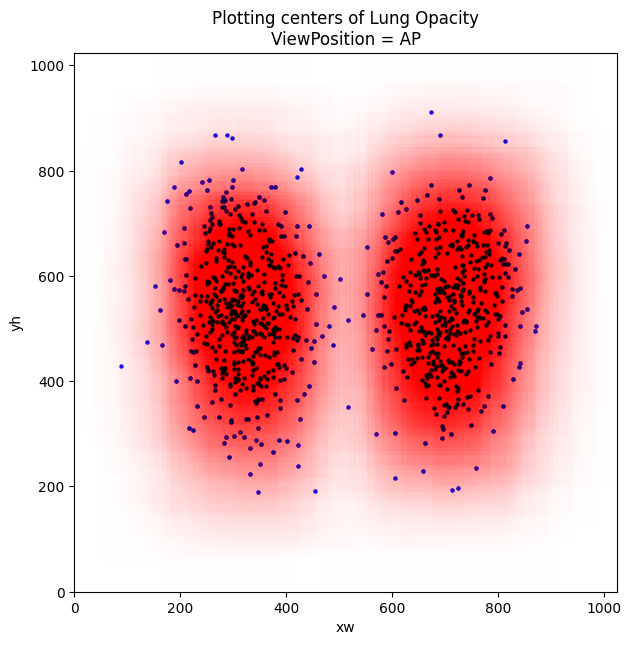

In [ ]:
bboxes_scatter(data_AP, 'blue', 'red', 'ViewPosition = AP')

We can see that the centers of the box are spread across the entire region of the Lungs. Both of the cases (PA and AP) seem to have outliers in them.  

#### Conversion Type

In [ ]:
print('Conversion Type for the data in Training Data: ', training_data['ConversionType'].unique()[0])

Conversion Type for the data in Training Data:  WSD


#### Rows and Columns

In [ ]:
print(f'The training images has {training_data.Rows.unique()[0]} rows and {training_data.Columns.unique()[0]} columns.')

The training images has 1024 rows and 1024 columns.


#### Patient Age

In [ ]:
print('The minimum and maximum recorded age of the patients are {} and {} respectively.'.format(training_data['PatientAge'].min(), training_data['PatientAge'].max()))

The minimum and maximum recorded age of the patients are 1 and 155 respectively.


The number of outliers in `PatientAge` out of 30277 records are:  5

The ages which are in the outlier categories are: [148, 151, 153, 150, 155]


Text(0.5, 1.0, 'Outliers in PatientAge')

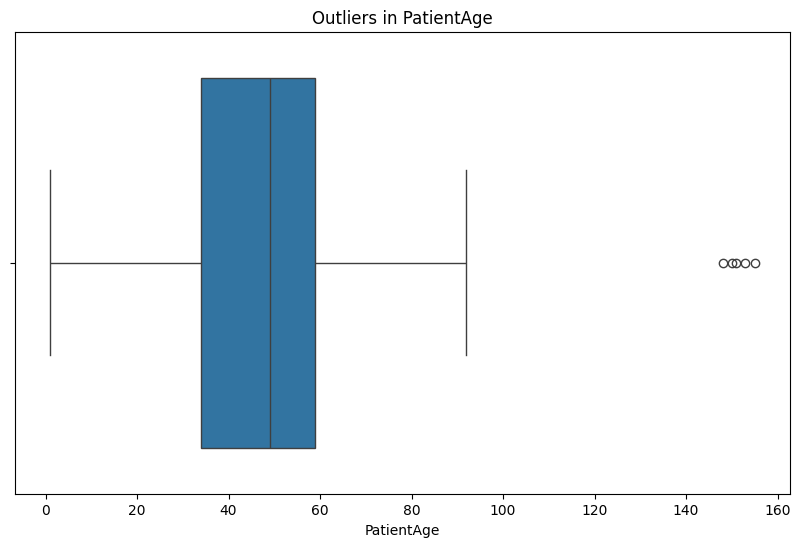

In [ ]:
age_25 = np.percentile(training_data['PatientAge'], 25)
age_75 = np.percentile(training_data['PatientAge'], 75)
iqr_age = age_75 - age_25
cutoff_age = 1.5 * iqr_age

low_lim_age = age_25 - cutoff_age
upp_lim_age = age_75 + cutoff_age

outlier_age = [x for x in training_data['PatientAge'] if x < low_lim_age or x > upp_lim_age]
print('The number of outliers in `PatientAge` out of 30277 records are: ', len(outlier_age))
print('\nThe ages which are in the outlier categories are:', outlier_age)

fig = plt.figure(figsize = (10, 6))
sns.boxplot(training_data['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

Thus, we can say that the ages like 148, 150, 151, 153 and 155 are mistakes. We can trim these outlier values to a somewhat lower value say 100 so that the max age of the patient will be 100.

In order to have a more clear idea, we will introduce a new column where the patients will be placed in an age group like (0, 10), (10, 20) etc.

In [ ]:
print('Removing the outliers from `PatientAge`')
training_data['PatientAge'] = training_data['PatientAge'].clip(training_data['PatientAge'].min(), 100)
training_data['PatientAge'].describe().astype(int)

Removing the outliers from `PatientAge`


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

Distribution of `PatientAge`: Overall and Target = 1


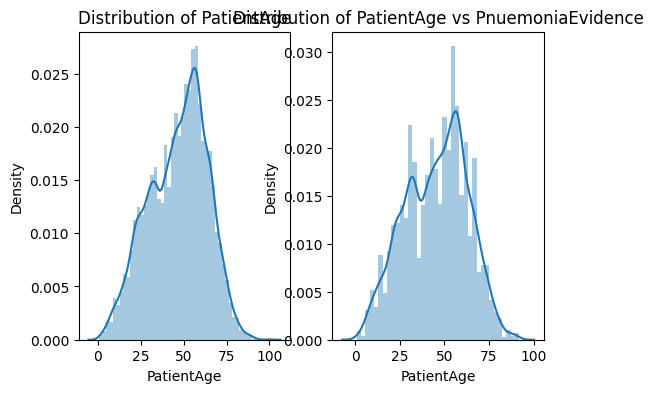

In [ ]:
print('Distribution of `PatientAge`: Overall and Target = 1')
fig = plt.figure(figsize = (6, 4))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['PatientAge']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'PatientAge']).set_title('Distribution of PatientAge vs PnuemoniaEvidence'))

In [ ]:
custom_array = np.linspace(0, 100, 11)
training_data['PatientAgeBins'] = pd.cut(training_data['PatientAge'], custom_array)
training_data['PatientAgeBins'].value_counts()

PatientAgeBins
(50.0, 60.0]     7446
(40.0, 50.0]     5671
(60.0, 70.0]     4730
(30.0, 40.0]     4551
(20.0, 30.0]     3704
(10.0, 20.0]     1688
(70.0, 80.0]     1637
(0.0, 10.0]       515
(80.0, 90.0]      275
(90.0, 100.0]      10
Name: count, dtype: int64

Thus, we can see that the maximum number of patients belong to the age group of [50, 60] whereas the least belong to [90, 100]

In [ ]:
print('After adding the bin column, the dataset turns out to be:\n')
training_data.head()

After adding the bin column, the dataset turns out to be:



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         51   
1  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         48   
2  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         19   
3  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         28   
4  /content/drive/MyDrive/zipOut/stage_2_train_im...       CR         32   

  PatientSex BodyPartExamined ViewPosition ConversionType  Rows Columns  \
0          F            CHEST           PA            WSD  1024    1024   
1          F            CHEST           PA            WSD  1024    1024   
2          M            CHEST           AP            WSD  1024    1024   
3          M            CHEST           PA            WSD  1024    1024   
4          F            CHEST           AP            WSD  1024    1024   

  PixelSpacing PatientAgeBins  
0        0.143   (50.0, 60.0]  
1        0.194   (40.0, 50.0]  
2        0.168   (10.0, 20.0]  
3        0.143   (20.0, 30.0]  
4        0.139   (30.0, 40.0]

From the above three plots we can infer that the maximum percentage of Male and Females, Patients with “No Lung Opacity / Not Normal” as well as “Lung Opacity” classes and Patients having Pneumonia all lies in the [50, 60] age group.

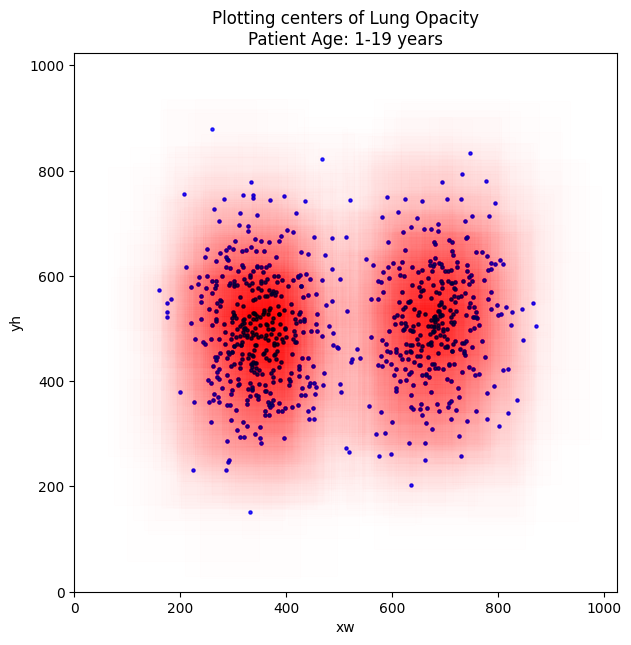

In [ ]:
data_age_19 = bboxes[bboxes['PatientAge'] < 20]
data_age_20_34 = bboxes[(bboxes['PatientAge'] >= 20) & (bboxes['PatientAge'] < 35)]
data_age_35_49 = bboxes[(bboxes['PatientAge'] >= 35) & (bboxes['PatientAge'] < 50)]
data_age_50_64 = bboxes[(bboxes['PatientAge'] >= 50) & (bboxes['PatientAge'] < 65)]
data_age_65 = bboxes[bboxes['PatientAge'] >= 65]

bboxes_scatter(data_age_19,'blue', 'red', 'Patient Age: 1-19 years')

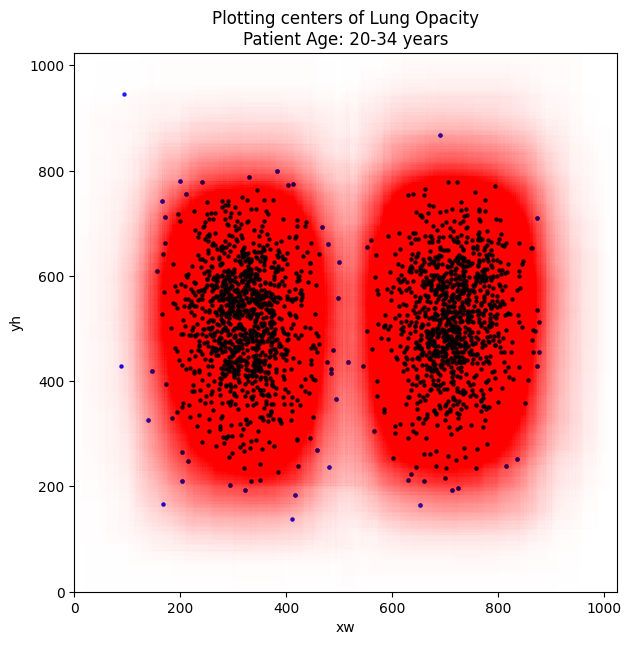

In [ ]:
bboxes_scatter(data_age_20_34, 'blue', 'red', 'Patient Age: 20-34 years')

In [ ]:
bboxes_scatter(data_age_35_49, 'blue', 'red', 'Patient Age: 35-49 years')

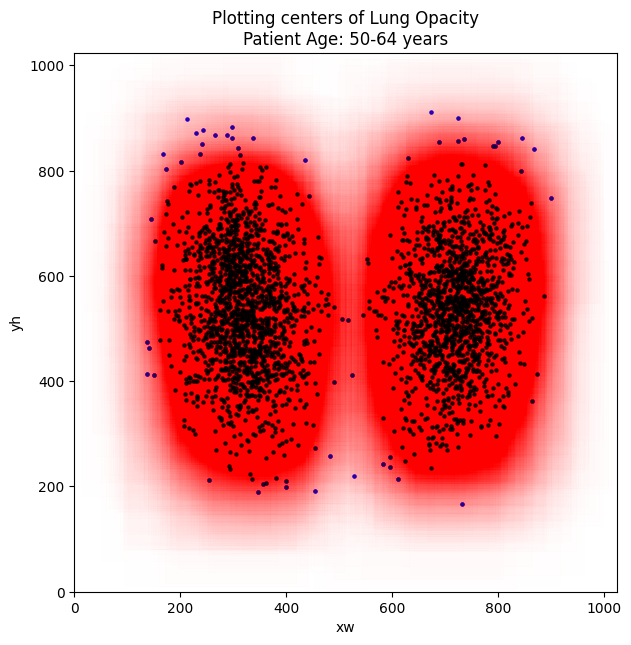

In [ ]:
bboxes_scatter(data_age_50_64, 'blue', 'red', 'Patient Age: 50-64 years')

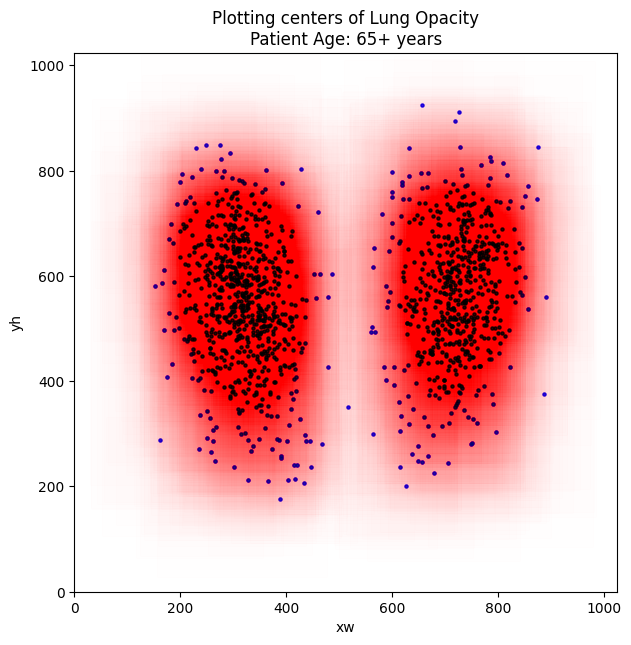

In [ ]:
bboxes_scatter(data_age_65, 'blue', 'red', 'Patient Age: 65+ years')

#### Plotting DICOM Images

In [ ]:
def show_dicom_images(data, df, img_path):
  img_data = list(data.T.to_dict().values())
  f, ax = plt.subplots(3, 3, figsize = (16, 18))

  for i, row in enumerate(img_data):
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    data = dcm.read_file(path)
    rows = df[df['patientId'] == row['patientId']]
    age = rows.PatientAge.unique().tolist()[0]
    sex = data.PatientSex
    part = data.BodyPartExamined
    vp = data.ViewPosition
    modality = data.Modality
    data_img = dcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                            .format(row['patientId'], age, sex, part,
                                    vp, modality, row['Target'],
                                    row['class'], row['x'],
                                    row['y'], row['width'],
                                    row['height']))
    box_data = list(rows.T.to_dict().values())

    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

- Target = 0

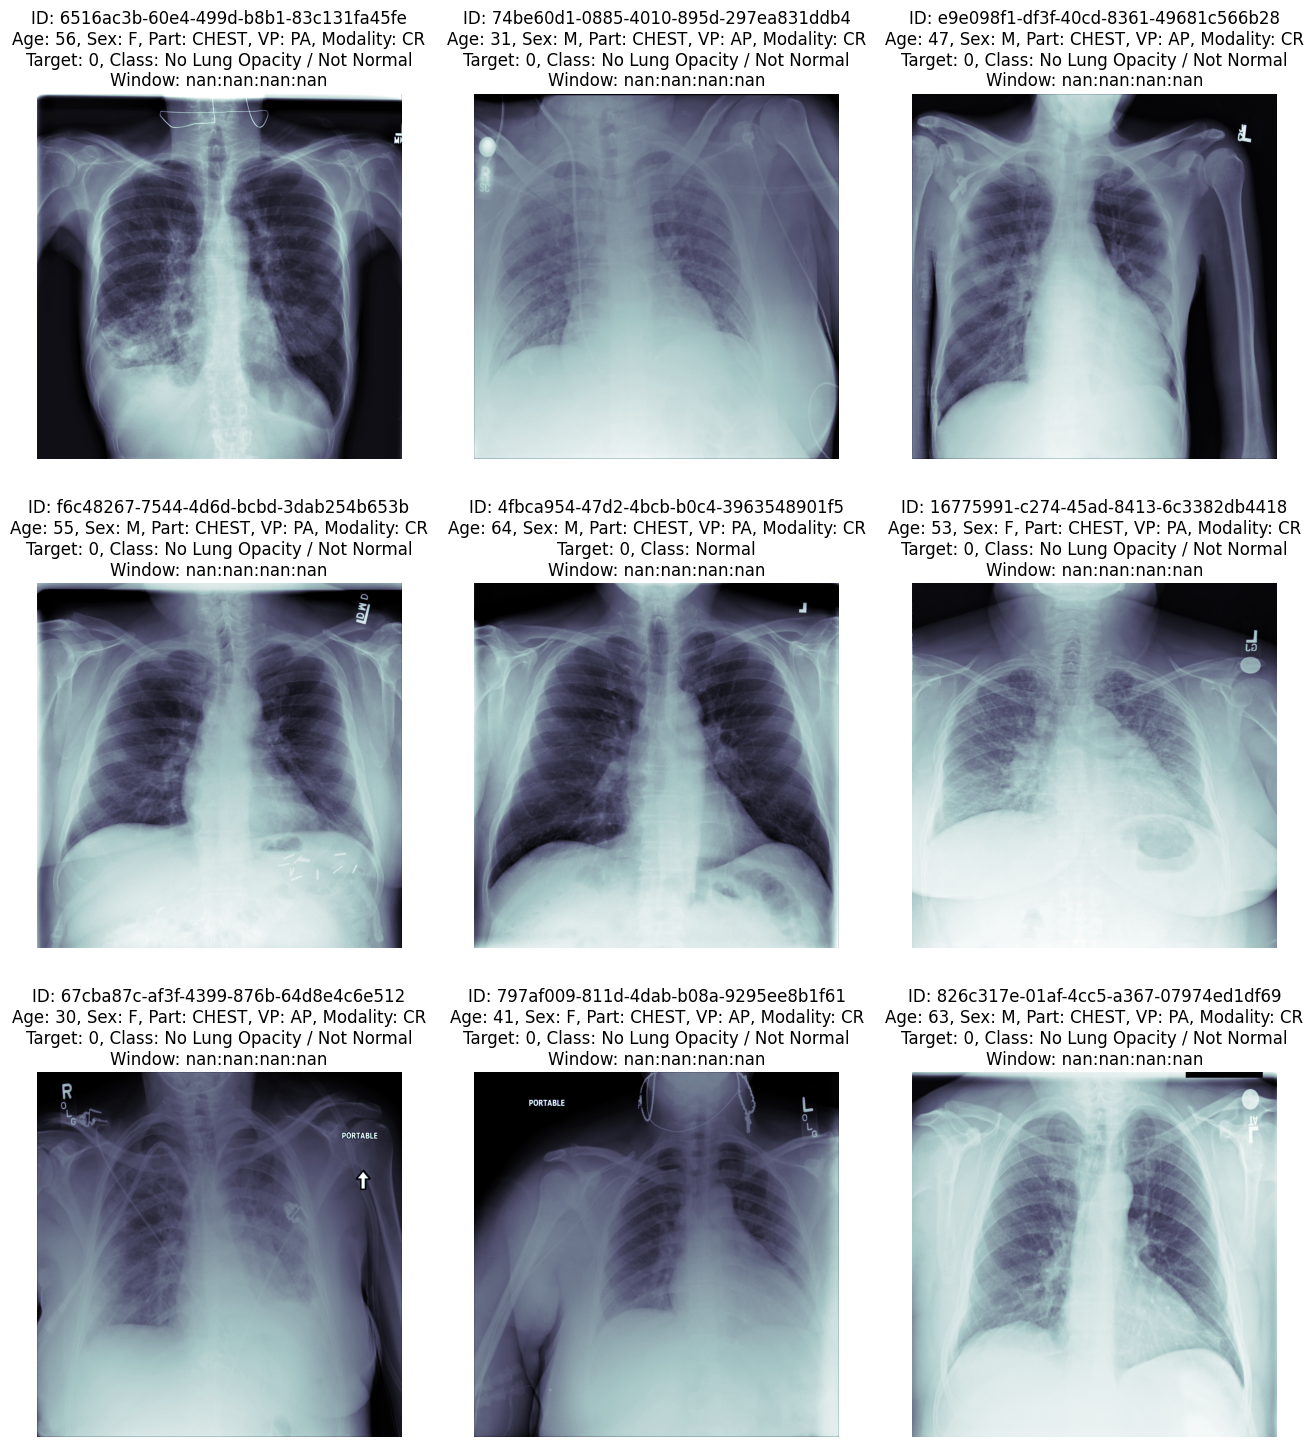

In [ ]:
show_dicom_images(data = training_data.loc[(training_data['Target'] == 0)].sample(9),
                  df = training_data, img_path = '/content/drive/MyDrive/zipOut/stage_2_train_images/')

As the above subplots are of the images which belong to either "Normal" or "No Lung Opacity / Not Normal", hence no bounding box is observed.

- Target = 1

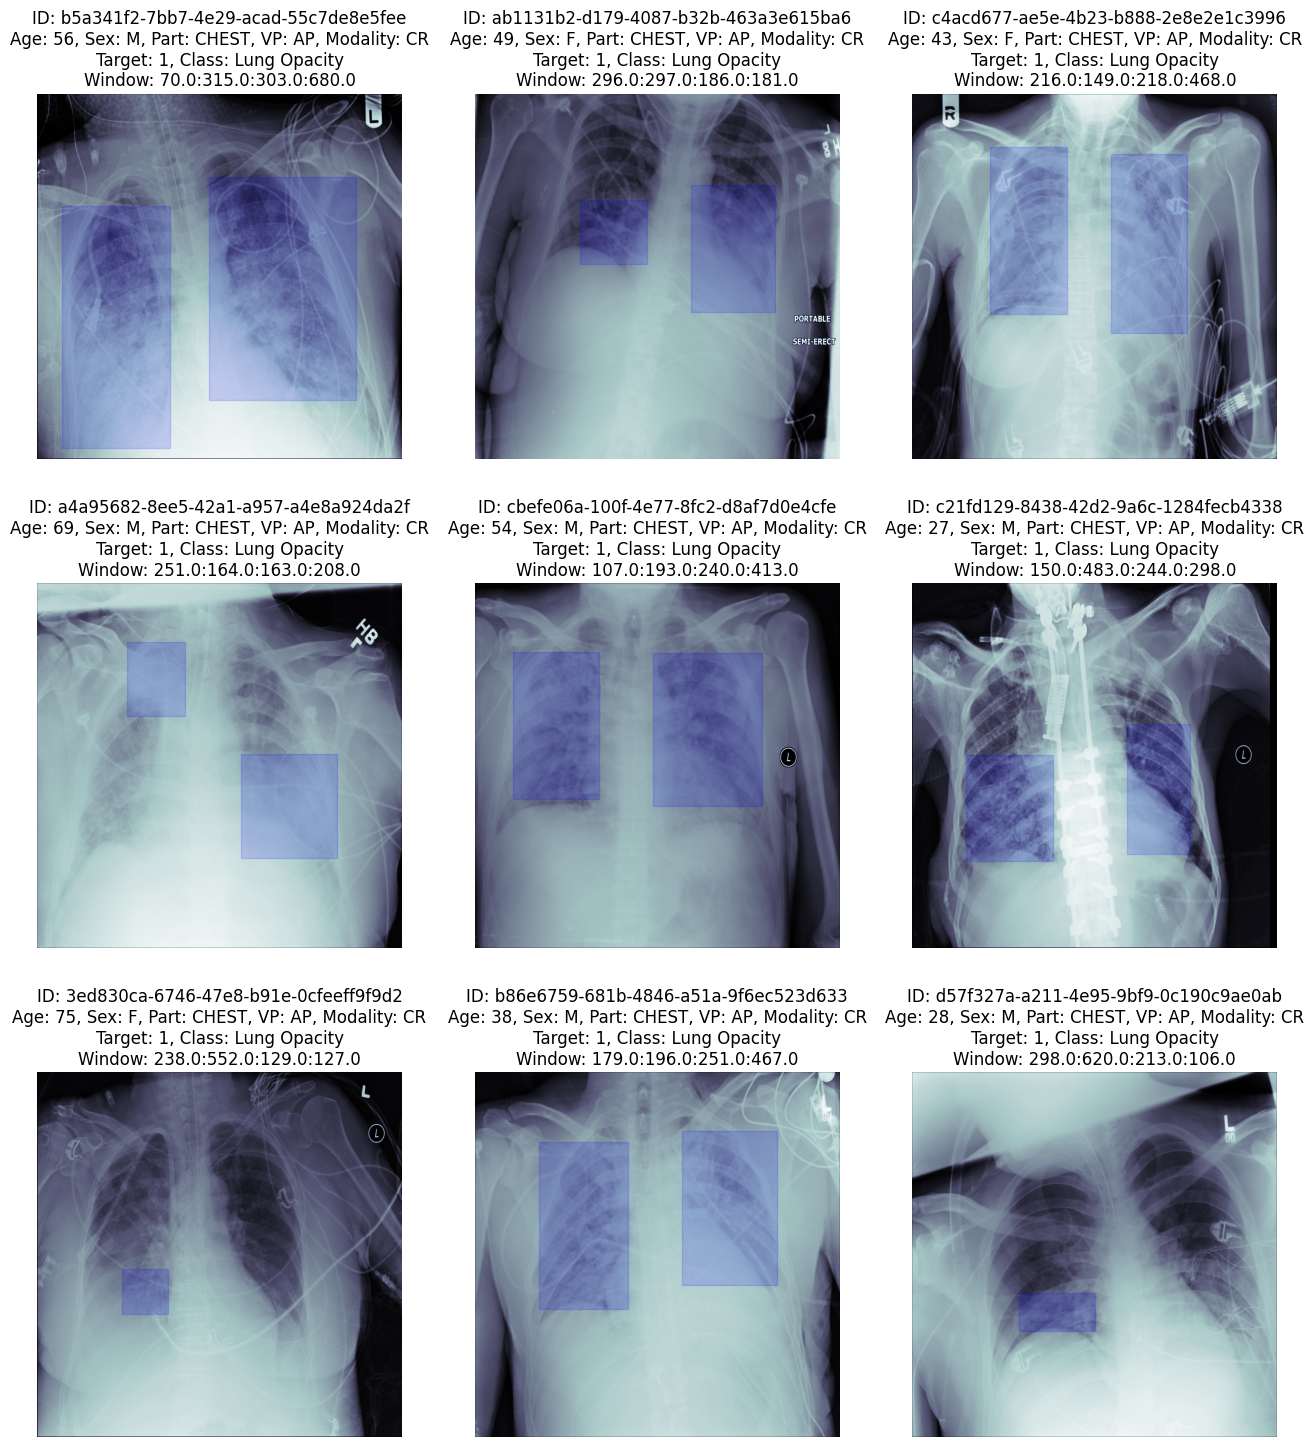

In [ ]:
show_dicom_images(data = training_data.loc[(training_data['Target'] == 1)].sample(9),
                  df = training_data, img_path = '/content/drive/MyDrive/zipOut/stage_2_train_images/')

In the above subplots, we can see that the area covered by the box (in blue colour) depicts the area of interest i.e., the area in which the opacity is observed in the Lungs.

### Conclusion
- The training dataset (both of the csv files and the training image folder) contains information of 26684 patients (unique)
- Out of these 26684 unique patients some of these have multiple entries in the both of the csv files
- Most of the recorded patient belong to Target = 0 (i.e., they don't have Pneumonia)
- Some of the patients have more than one bounding box. The maximum being 4
- The classes "No Lung Opacity / Not Normal" and "Normal" is associated with Target = 0 whereas "Lung Opacity" belong to Target = 1
- The images are present in dicom format, from which information like PatientAge, PatientSex, ViewPosition etc are obtained
- There are two ways from which images were obtained: AP and PA. The age ranges from 1-155 (which were further clipped to 100)
- The centers of the bounding box are spread out over the entire region of the lungs. But there are some centers which are outliers.

## Design, train and test basic CNN models for classification

In [ ]:
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

train_class = pd.read_csv('/content/drive/MyDrive/datasets/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/datasets/stage_2_train_labels.csv')

train_path = Path('/content/drive/MyDrive/zipOut/stage_2_train_images')
test_path = Path('/content/drive/MyDrive/zipOut/stage_2_test_images')

train_meta = pd.concat([train_labels,
                        train_class.drop(columns=['patientId'])], axis=1)

box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')

train_ds = pd.merge(train_meta, box_df, on='patientId')

box_df = box_df.groupby('boxes').size().reset_index(name='patients')


# List of information we needs with us
vars = ['PatientAge','PatientSex','ImagePath']


def process_dicom_data(df, path):

    # adding new columns to the imported DataFrame with Null values
    for var in vars:
        df[var] = None

    images = os.listdir(path)

    #looping through each dicom image, extract the information from it, and
    # add it to the DataFrame

    for i, img_name in tqdm(enumerate(images)):

        imagePath = os.path.join(path,img_name)
        img_data = dcm.read_file(imagePath)

        idx = (df['patientId']==img_data.PatientID)
        df.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        df.loc[idx,'PatientSex'] = img_data.PatientSex
        df.loc[idx, 'ImagePath'] = str.format(imagePath)

process_dicom_data(train_ds,'/content/drive/MyDrive/zipOut/stage_2_train_images')

26684it [07:09, 62.10it/s] 


In [ ]:
train_ds.to_csv('pneumonia_ds', index=False)

#### Pre Processing the image

In [ ]:
import cv2

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/content/drive/MyDrive/zipOut/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array

## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)

        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

images, labels = populateImage(train_meta)
print(images.shape , labels.shape)

(30227, 128, 128, 3) (30227,)


Scikitlearn suggests using OneHotEncoder for X matrix i.e. the features you feed in a model, and to use a LabelBinarizer for the y labels.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()
y = encode.fit_transform(labels)

## splitting into train ,test and validation data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

CNN Model

In [ ]:
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation,Flatten,Dropout,MaxPooling2D,BatchNormalization

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses,optimizers

In [ ]:
## We start with 32 filters with 3,3 kernal and no padding , then 64 and 128 wiht drop layers in between
## And softmax activaation as the last layer

def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = Adam(lr=0.001)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

Model Summary

In [ ]:
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

Training for 20 epocs with batch size of 16

In [ ]:
history = cnn.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 [==============================] - 43s 26ms/step - loss: 1.1691 - accuracy: 0.4095 - val_loss: 1.0307 - val_accuracy: 0.4404
Epoch 2/20
1323/1323 [==============================] - 33s 25ms/step - loss: 1.0226 - accuracy: 0.4485 - val_loss: 1.0039 - val_accuracy: 0.4580
Epoch 3/20
1323/1323 [==============================] - 33s 25ms/step - loss: 1.0036 - accuracy: 0.4618 - val_loss: 0.9891 - val_accuracy: 0.4675
Epoch 4/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9943 - accuracy: 0.4741 - val_loss: 0.9966 - val_accuracy: 0.4712
Epoch 5/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9950 - accuracy: 0.4800 - val_loss: 0.9769 - val_accuracy: 0.4931
Epoch 6/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9825 - accuracy: 0.4851 - val_loss: 0.9747 - val_accuracy: 0.5052
Epoch 7/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9979 - accuracy: 0.4711 - val_loss: 0.9738 -

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

In [ ]:
history = cnn.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16,
                 callbacks = callbacks)

Epoch 1/20
1323/1323 [==============================] - 34s 25ms/step - loss: 0.9881 - accuracy: 0.4836 - val_loss: 0.9777 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 2/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9708 - accuracy: 0.4938 - val_loss: 0.9594 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 3/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9654 - accuracy: 0.5005 - val_loss: 0.9576 - val_accuracy: 0.4873 - lr: 0.0010
Epoch 4/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9645 - accuracy: 0.5006 - val_loss: 0.9526 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 5/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9634 - accuracy: 0.4979 - val_loss: 0.9496 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 6/20
1323/1323 [==============================] - 33s 25ms/step - loss: 0.9651 - accuracy: 0.5014 - val_loss: 0.9565 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 7/20
1323/1323 [========================

Training accuracy is around 49.99 percent whereas validation accuracy is round 50.83 percent. We have avoided overfitting, but it seems to be clear that a normal CNN will not help us.

In [ ]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

142/142 [==============================] - 1s 10ms/step - loss: 0.9490 - accuracy: 0.5143
Test loss: 0.9489631056785583
Test accuracy: 0.514336109161377


In [ ]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

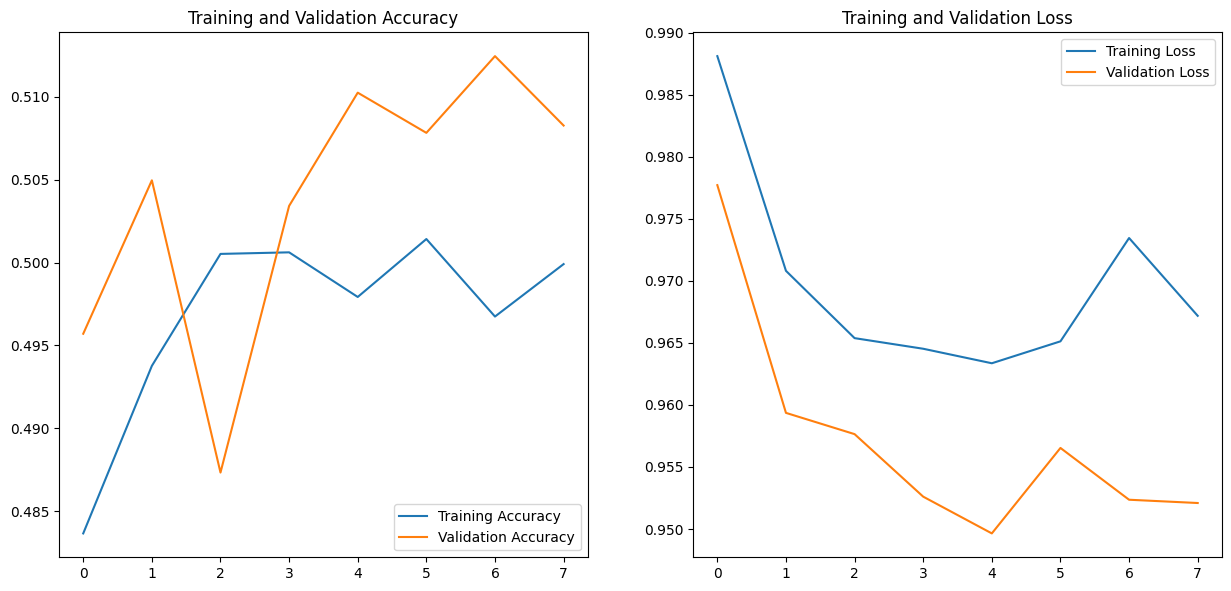

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))  # This ensures the range matches the length of your data

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

In [ ]:
resultDF

Method  accuracy  Test Score
0    CNN  0.499905    0.514336

142/142 [==============================] - 1s 9ms/step


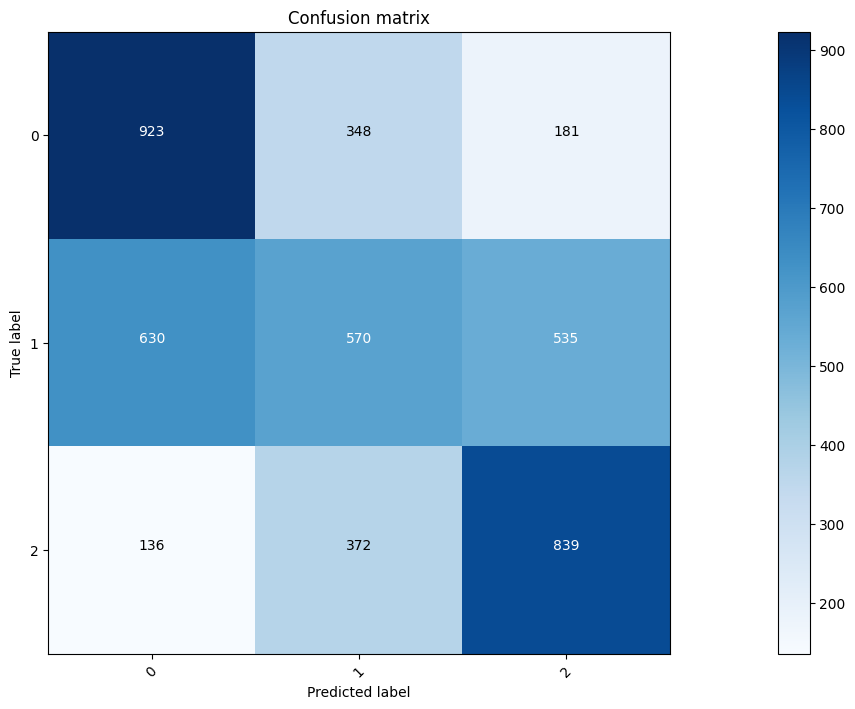

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Not Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal



```
# This is formatted as code
```

The Metrics indcates the class 0 & 2 are being predicted well by the model, however class 1 requires further improvement.  

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1)

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

142/142 [==============================] - 1s 9ms/step


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN  0.499905    0.514336      0.44186   0.32853     0.37686       1735

The Model requires further fine tuning, to have even more precise predictions on detecting the Pnemonia.

**Training Accuracy:** Slightly increasing over epochs, indicating the model is learning from the training data.

**Training Loss:** Gradually decreasing, indicating the model is effectively learning.

**Validation Loss:** Decreasing overall, but with fluctuations, suggesting the model is improving but may still be overfitting slightly or learning at an unstable rate.Need to increase data or use augmentation to improve generalization.

##Milestone 2 - Training and tuning Models for Pneumonia Detection

In [ ]:
import numpy as np
import pandas as pd
import os
import pydicom
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import seaborn as sns


from matplotlib import pyplot as plt

In [ ]:
#Using a datagenerator to optimize memory usage and keep the image size at 512*512

class DicomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, data_dir, batch_size=4, img_size=512, shuffle=True, subset='training'):
        self.df = df
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.subset = subset
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        X, y = self.__data_generation(batch_df)

        return X, y

    def on_epoch_end(self):
        if self.subset == 'training':
            self.indices = np.arange(len(self.df))
            if self.shuffle:
                np.random.shuffle(self.indices)
        elif self.subset == 'validation':
            self.indices = np.arange(len(self.df))

    def __data_generation(self, batch_df):
        X = np.empty((len(batch_df), self.img_size, self.img_size, 1))
        y = np.empty((len(batch_df)), dtype=int)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            file_path = os.path.join(self.data_dir, row['patientId'] + '.dcm')
            ds = pydicom.dcmread(file_path)
            img = ds.pixel_array
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0  # Normalize the image

            # Expand dimensions to make it (1024, 1024, 1)
            X[i,] = np.expand_dims(img, axis=-1)

            # Assign the label
            y[i] = int(row['Target'])

        return X, y



# Loading and splitting into train, validation, and test sets
data_dir = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
labels_df = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')


In [ ]:
from sklearn.model_selection import train_test_split


# Split into train, validation, and test sets
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


In [ ]:
import numpy as np

# Parameters
batch_size = 4
img_size = 512

# Initialize generators for train, validation, and test sets
train_generator = DicomDataGenerator(train_df, data_dir, batch_size=batch_size, img_size=img_size, subset='training')
val_generator = DicomDataGenerator(val_df, data_dir, batch_size=batch_size, img_size=img_size, subset='validation')
test_generator = DicomDataGenerator(test_df, data_dir, batch_size=batch_size, img_size=img_size, subset='validation')


In [ ]:
#Basic CNN Model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   251,920,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,014,081 (961.36 MB)

 Trainable params: 252,014,081 (961.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Fitting the model

model.fit(train_generator, epochs=5, validation_data=val_generator)


Epoch 1/5


2024-06-21 18:12:45.702711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.19583, expected 2.2314
2024-06-21 18:12:45.702780: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.61042, expected 1.646
2024-06-21 18:12:45.702789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.56807, expected 1.60364
2024-06-21 18:12:45.702797: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.14259, expected 2.17816
2024-06-21 18:12:45.702805: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.8223, expected 1.85788
2024-06-21 18:12:45.702812: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.01424, expected 2.04982
2024-06-21 18:12:45.702820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.73762, expected 2.7732
2024-06-21 18:12:45.702827: E external/local_xla/xla/service

   3/5441 ━━━━━━━━━━━━━━━━━━━━ 6:12 69ms/step - accuracy: 0.2917 - loss: 22.7386    

I0000 00:00:1718993571.450613     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718993571.469478     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1116/5441 ━━━━━━━━━━━━━━━━━━━━ 4:49 67ms/step - accuracy: 0.6545 - loss: 2.7868

2024-06-21 18:14:06.551561: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.03991, expected 2.3779
2024-06-21 18:14:06.551622: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.84086, expected 2.17885
2024-06-21 18:14:06.551632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.82741, expected 2.1654
2024-06-21 18:14:06.551641: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.87941, expected 2.2174
2024-06-21 18:14:06.551648: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.6931, expected 3.03109
2024-06-21 18:14:06.551656: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.9916, expected 3.32959
2024-06-21 18:14:06.551663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.02855, expected 2.36654
2024-06-21 18:14:06.551671: E external/local_xla/xla/service

1119/5441 ━━━━━━━━━━━━━━━━━━━━ 5:05 71ms/step - accuracy: 0.6546 - loss: 2.7822

W0000 00:00:1718993650.359440     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6758 - loss: 1.2091

W0000 00:00:1718993926.465461     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-21 18:19:20.395446: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4199: 0.978102, expected 0.772126
2024-06-21 18:19:20.395513: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5049: 0.932037, expected 0.726061
2024-06-21 18:19:20.395529: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6215: 0.803031, expected 0.597055
2024-06-21 18:19:20.395539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6725: 0.865835, expected 0.659859
2024-06-21 18:19:20.395552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6961: 1.04407, expected 0.838099
2024-06-21 18:19:20.395563: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7549: 1.04724, expected 0.841261
2024-06-21 18:19:20.395574: E externa

5441/5441 ━━━━━━━━━━━━━━━━━━━━ 401s 72ms/step - accuracy: 0.6758 - loss: 1.2090 - val_accuracy: 0.6763 - val_loss: 0.6297
Epoch 2/5


W0000 00:00:1718993962.318353     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 291s 53ms/step - accuracy: 0.6829 - loss: 0.6248 - val_accuracy: 0.6763 - val_loss: 0.6299
Epoch 3/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 291s 53ms/step - accuracy: 0.6855 - loss: 0.6228 - val_accuracy: 0.6763 - val_loss: 0.6297
Epoch 4/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 292s 54ms/step - accuracy: 0.6867 - loss: 0.6219 - val_accuracy: 0.6763 - val_loss: 0.6298
Epoch 5/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 292s 54ms/step - accuracy: 0.6848 - loss: 0.6233 - val_accuracy: 0.6763 - val_loss: 0.6298


In [ ]:
# Evaluate the model on training, validation, and testing data
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 172s 32ms/step - accuracy: 0.6861 - loss: 0.6222
  1/605 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.5000 - loss: 0.7668

W0000 00:00:1718995300.584891     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


605/605 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.6785 - loss: 0.6281
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.6956 - loss: 0.6148


In [ ]:
# Creating a dataframe with evaluation metrics of each model

import pandas as pd

metrics_df = pd.DataFrame(columns=[
    'Model',
    'Training Loss', 'Training Accuracy',
    'Validation Loss', 'Validation Accuracy',
    'Testing Loss', 'Testing Accuracy'
])

print(metrics_df)

# Create a dictionary with the metrics
model_metrics = {
    'Model': "CNN Base Model",
    'Training Loss': train_loss, 'Training Accuracy': train_acc,
    'Validation Loss': val_loss, 'Validation Accuracy': val_acc,
    'Testing Loss': test_loss, 'Testing Accuracy': test_acc,

}

# Append the metrics to the DataFrame
model_metrics_df = pd.DataFrame([model_metrics])
metrics_df = pd.concat([metrics_df,model_metrics_df], ignore_index=True)

# Print the DataFrame to check the added metrics
metrics_df


Empty DataFrame
Columns: [Model, Training Loss, Training Accuracy, Validation Loss, Validation Accuracy, Testing Loss, Testing Accuracy]
Index: []


Model  Training Loss  Training Accuracy  Validation Loss  \
0  CNN Base Model       0.623253           0.684726         0.629796   

   Validation Accuracy  Testing Loss  Testing Accuracy  
0             0.676313      0.623872          0.683923

In [ ]:
metrics_df.to_csv('/kaggle/working/accuracy_metrics.csv', index=False)

In [ ]:
# Save the model
model.save('/kaggle/working/cnn_base_model.keras')

*Above basic CNN model gives us a testing accuracy of about 68%. We will try to improve on this by increasing the number of layers and using some regularisation techniques to avoid overfitting*

**Regularising & Improving the Base CNN Model**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


def create_model(input_shape=(512, 512, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),


        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Initialize the model
model = create_model()

In [ ]:
# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [ ]:
import cv2

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/5
   3/5441 ━━━━━━━━━━━━━━━━━━━━ 4:08 46ms/step - accuracy: 0.5694 - loss: 9.9505   

W0000 00:00:1718995443.520817     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2631/5441 ━━━━━━━━━━━━━━━━━━━━ 2:23 51ms/step - accuracy: 0.6574 - loss: 25.1266

W0000 00:00:1718995577.887873     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6656 - loss: 16.6215

W0000 00:00:1718995702.773932     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718995722.654829     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 308s 52ms/step - accuracy: 0.6656 - loss: 16.6197 - val_accuracy: 0.6755 - val_loss: 1.9177
Epoch 2/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 267s 49ms/step - accuracy: 0.6747 - loss: 1.8139 - val_accuracy: 0.7255 - val_loss: 0.7162
Epoch 3/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 268s 49ms/step - accuracy: 0.7276 - loss: 0.6608 - val_accuracy: 0.7404 - val_loss: 0.6033
Epoch 4/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 270s 50ms/step - accuracy: 0.7527 - loss: 0.5861 - val_accuracy: 0.7528 - val_loss: 0.5957
Epoch 5/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 269s 49ms/step - accuracy: 0.7605 - loss: 0.5853 - val_accuracy: 0.7751 - val_loss: 0.5505


In [ ]:
# Evaluate the model on training, validation, and testing data
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

5441/5441 ━━━━━━━━━━━━━━━━━━━━ 174s 32ms/step - accuracy: 0.7804 - loss: 0.5423
  1/605 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.5000 - loss: 1.0476

W0000 00:00:1718996976.088611     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


605/605 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7722 - loss: 0.5605
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.7786 - loss: 0.5488


In [ ]:
new_metrics = {
    'Model': "Regularized CNN Model",
    'Training Loss': train_loss, 'Training Accuracy': train_acc,
    'Validation Loss': val_loss, 'Validation Accuracy': val_acc,
    'Testing Loss': test_loss, 'Testing Accuracy': test_acc
}
new_metrics_df = pd.DataFrame([new_metrics])

# Load the existing CSV file
csv_file = '/kaggle/working/accuracy_metrics.csv'

existing_metrics = pd.read_csv(csv_file)

# Append the new metrics to the existing DataFrame
updated_metrics = pd.concat([existing_metrics, new_metrics_df], ignore_index=True)

# Save the updated DataFrame back to the CSV file
updated_metrics.to_csv(csv_file, index=False)

# Save the model
model.save('/kaggle/working/regularised_cnn_model.keras')

In [ ]:
print(updated_metrics)

                   Model  Training Loss  Training Accuracy  Validation Loss  \
0         CNN Base Model       0.623253           0.684726         0.629796   
1  Regularized CNN Model       0.541767           0.780673         0.550529   

   Validation Accuracy  Testing Loss  Testing Accuracy  
0             0.676313      0.623872          0.683923  
1             0.775114      0.554473          0.773900  


*The Regularised & Improved CNN Model has a testing accuracy of 77.39%. It doesn't overfit the data and the validation & testing losses being lower than the original model indcate that it does a good job of learning from the data.*

*We shall try to improve the model performance by employing Transfer Learning Methodologies next*

**Transfer Learning - VGG16**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from tensorflow.keras.optimizers import Adam


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


def create_vgg16_model(input_shape=(512, 512, 1)):
    # Load the VGG16 model pre-trained on ImageNet, without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

    # Convert grayscale to 3 channels by duplicating the single channel
    input_layer = Input(shape=input_shape)
    x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_layer)

    # Use the output of the base model as the new input
    x = base_model(x)

    # Add new fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Initialize the model
model = create_vgg16_model()

## Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg16_best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5


2024-06-21 19:10:57.263873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.26968, expected 2.80856
2024-06-21 19:10:57.263938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 146: 3.17124, expected 2.71012
2024-06-21 19:10:57.263957: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 467: 3.35129, expected 2.89017
2024-06-21 19:10:57.264318: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 56320: 3.50732, expected 3.0462
2024-06-21 19:10:57.264486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 73216: 3.24084, expected 2.77971
2024-06-21 19:10:57.264884: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 128512: 3.43029, expected 2.96917
2024-06-21 19:10:57.265068: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148480: 3.5364, expected 3.07528
2024-06-21 19:10:57.265196: E exter

   1/5441 ━━━━━━━━━━━━━━━━━━━━ 51:04:33 34s/step - accuracy: 0.7500 - loss: 1425.9535

W0000 00:00:1718997084.868118     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1413/5441 ━━━━━━━━━━━━━━━━━━━━ 10:36 158ms/step - accuracy: 0.6520 - loss: 48709.1562

2024-06-21 19:15:09.585483: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.96943, expected 4.13831
2024-06-21 19:15:09.585538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.82185, expected 5.99072
2024-06-21 19:15:09.585547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.62315, expected 5.79201
2024-06-21 19:15:09.585555: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.80174, expected 5.97062
2024-06-21 19:15:09.585563: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.5794, expected 4.74827
2024-06-21 19:15:09.585570: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.04486, expected 6.21373
2024-06-21 19:15:09.585578: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.86165, expected 6.03052
2024-06-21 19:15:09.585585: E external/local_xla/xla/ser

1414/5441 ━━━━━━━━━━━━━━━━━━━━ 11:27 171ms/step - accuracy: 0.6520 - loss: 48683.7305

W0000 00:00:1718997326.094125     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6733 - loss: 17118.5215

W0000 00:00:1718997964.376797     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-21 19:26:35.126184: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.58381, expected 3.71248
2024-06-21 19:26:35.126275: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.57184, expected 4.70052
2024-06-21 19:26:35.126290: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.08221, expected 4.21089
2024-06-21 19:26:35.126299: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.21032, expected 4.339
2024-06-21 19:26:35.126308: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.77947, expected 3.90814
2024-06-21 19:26:35.126327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.2979, expected 4.42658
2024-06-21 19:26:35.126334: E external/local_xla/xla/service/gpu/buf

5441/5441 ━━━━━━━━━━━━━━━━━━━━ 956s 170ms/step - accuracy: 0.6733 - loss: 17115.9844 - val_accuracy: 0.6763 - val_loss: 0.6544
Epoch 2/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 896s 165ms/step - accuracy: 0.6819 - loss: 0.6472 - val_accuracy: 0.6763 - val_loss: 0.6377
Epoch 3/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 896s 165ms/step - accuracy: 0.6882 - loss: 2.3013 - val_accuracy: 0.6763 - val_loss: 0.6320
Epoch 4/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 896s 165ms/step - accuracy: 0.6872 - loss: 0.6247 - val_accuracy: 0.6763 - val_loss: 0.6302
Epoch 5/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 896s 165ms/step - accuracy: 0.6836 - loss: 0.6251 - val_accuracy: 0.6763 - val_loss: 0.6297


In [ ]:
# Evaluate the model on training, validation, and testing data
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

5441/5441 ━━━━━━━━━━━━━━━━━━━━ 285s 52ms/step - accuracy: 0.6851 - loss: 0.6235


W0000 00:00:1719001877.268323     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


605/605 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.6785 - loss: 0.6282
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 80s 53ms/step - accuracy: 0.6956 - loss: 0.6160


In [ ]:
new_metrics = {
    'Model': "VGG16 Model",
    'Training Loss': train_loss, 'Training Accuracy': train_acc,
    'Validation Loss': val_loss, 'Validation Accuracy': val_acc,
    'Testing Loss': test_loss, 'Testing Accuracy': test_acc
}
new_metrics_df = pd.DataFrame([new_metrics])

# Load the existing CSV file
csv_file = '/kaggle/working/accuracy_metrics.csv'

existing_metrics = pd.read_csv(csv_file)

# Append the new metrics to the existing DataFrame
updated_metrics = pd.concat([existing_metrics, new_metrics_df], ignore_index=True)

# Save the updated DataFrame back to the CSV file
updated_metrics.to_csv(csv_file, index=False)

# Save the model
model.save('/kaggle/working/VGG16_model.keras')

In [ ]:
print(updated_metrics)

                   Model  Training Loss  Training Accuracy  Validation Loss  \
0         CNN Base Model       0.623253           0.684726         0.629796   
1  Regularized CNN Model       0.541767           0.780673         0.550529   
2            VGG16 Model       0.623735           0.684726         0.629697   

   Validation Accuracy  Testing Loss  Testing Accuracy  
0             0.676313      0.623872          0.683923  
1             0.775114      0.554473          0.773900  
2             0.676313      0.624291          0.683923  


*The VGG16 Transfer Learning model does not outperform the Improved and Regularised CNN Model as far as the accuracy is concerned. We shall try the ResNet50 Transfer Learning model next.*

**Transfer Learning - ResNet50 Model**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

def create_resnet50_model(input_shape=(512, 512, 1)):
    # Load the resnet50 model pre-trained on ImageNet, without the top (fully connected) layers
    base_model = ResNet50(include_top=False, weights='imagenet',input_shape =(512, 512, 3))

    # Convert grayscale to 3 channels by duplicating the single channel
    input_layer = Input(shape=input_shape)
    x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_layer)

    # Use the output of the base model as the new input
    x = base_model(x)

    # Add new fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Initialize the model
model = create_resnet50_model()

## Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


I0000 00:00:1719035506.888833      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719035506.985395      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3742/5441 ━━━━━━━━━━━━━━━━━━━━ 4:17 152ms/step - accuracy: 0.6930 - loss: 1.2237

W0000 00:00:1719036075.099482      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7086 - loss: 1.0445

W0000 00:00:1719036323.091664      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719036357.246286      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5441/5441 ━━━━━━━━━━━━━━━━━━━━ 944s 160ms/step - accuracy: 0.7086 - loss: 1.0445 - val_accuracy: 0.7495 - val_loss: 0.5590
Epoch 2/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 829s 152ms/step - accuracy: 0.7888 - loss: 0.4741 - val_accuracy: 0.8078 - val_loss: 0.4481
Epoch 3/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 812s 149ms/step - accuracy: 0.8129 - loss: 0.4195 - val_accuracy: 0.7664 - val_loss: 1.3505
Epoch 4/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 814s 150ms/step - accuracy: 0.8273 - loss: 0.3990 - val_accuracy: 0.8074 - val_loss: 0.4699
Epoch 5/5
5441/5441 ━━━━━━━━━━━━━━━━━━━━ 815s 150ms/step - accuracy: 0.8406 - loss: 0.3659 - val_accuracy: 0.7350 - val_loss: 0.4855


In [ ]:
# Evaluate the model on training, validation, and testing data
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

5441/5441 ━━━━━━━━━━━━━━━━━━━━ 223s 41ms/step - accuracy: 0.8164 - loss: 0.4374
605/605 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.7897 - loss: 0.4581
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 61s 40ms/step - accuracy: 0.8120 - loss: 0.4445


In [ ]:
new_metrics = {
    'Model': "ResNet50 Model",
    'Training Loss': train_loss, 'Training Accuracy': train_acc,
    'Validation Loss': val_loss, 'Validation Accuracy': val_acc,
    'Testing Loss': test_loss, 'Testing Accuracy': test_acc
}
new_metrics_df = pd.DataFrame([new_metrics])

# Load the existing CSV file
csv_file = '/kaggle/working/accuracy_metrics.csv'

existing_metrics = pd.read_csv(csv_file)

# Append the new metrics to the existing DataFrame
updated_metrics = pd.concat([existing_metrics, new_metrics_df], ignore_index=True)

# Save the updated DataFrame back to the CSV file
updated_metrics.to_csv(csv_file, index=False)

# Save the model
model.save('/kaggle/working/ResNet50_model.keras')

In [ ]:
import pandas as pd
pd.read_csv('/kaggle/working/accuracy_metrics.csv')

Model  Training Loss  Training Accuracy  Validation Loss  \
0         CNN Base Model       0.623253           0.684726         0.629796   
1  Regularized CNN Model       0.541767           0.780673         0.550529   
2            VGG16 Model       0.623735           0.684726         0.629697   
3         ResNet50 Model       0.434548           0.817572         0.448078   

   Validation Accuracy  Testing Loss  Testing Accuracy  
0             0.676313      0.623872          0.683923  
1             0.775114      0.554473          0.773900  
2             0.676313      0.624291          0.683923  
3             0.807772      0.447309          0.810288

*ResNet50 does the best job so far among all the models in identifying Pneumonia markers among the images with an accuracy of 81.02% on the testing dataset. We make a recommendation of this model for identifying pneumonia images since it outperforms the rest*

*Below are other some additional performance metrics for the ResNet50 Tranfer Learning Model:*

In [ ]:
import os
import sys
import numpy as np
from sklearn.metrics import precision_score, recall_score

class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def compute_metrics(generator):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        y_true.extend(y_batch)
        with SuppressOutput():
            preds = model.predict(X_batch)
        y_pred.extend(preds.flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred) > 0.5  # Threshold for binary classification

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return precision, recall

# Compute precision and recall for train, validation, and test sets
train_precision, train_recall = compute_metrics(train_generator)
val_precision, val_recall = compute_metrics(val_generator)
test_precision, test_recall = compute_metrics(test_generator)

print(f"Train Precision: {train_precision}, Train Recall: {train_recall}")
print(f"Validation Precision: {val_precision}, Validation Recall: {val_recall}")
print(f"Test Precision: {test_precision}, Test Recall: {test_recall}")

W0000 00:00:1719046308.564109      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719046392.379081      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Train Precision: 0.6894247149783777, Train Recall: 0.7667978428800466
Validation Precision: 0.6939024390243902, Validation Recall: 0.7266922094508301
Test Precision: 0.6793427230046948, Test Recall: 0.7571951857666144


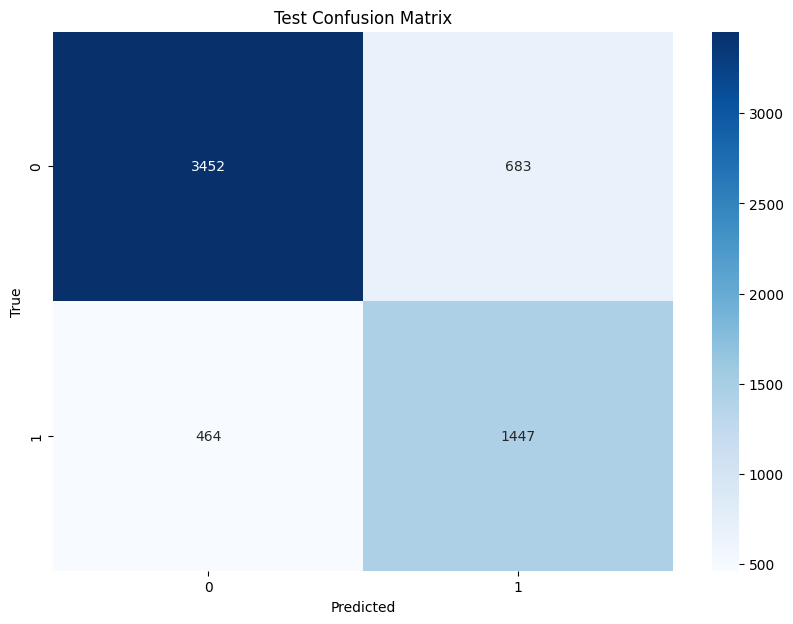

In [ ]:
# Plotting Confusion matrix

from sklearn.metrics import confusion_matrix


class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def compute_metrics(generator):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        y_true.extend(y_batch)
        with SuppressOutput():
            preds = model.predict(X_batch)
        y_pred.extend(preds.flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred) > 0.5

    return y_true, y_pred

# Get predictions and true labels
y_true_test, y_pred_test = compute_metrics(test_generator)

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrix for test set
plot_confusion_matrix(y_true_test, y_pred_test, title='Test Confusion Matrix')

* *Testing precision is at 68% and the testing recall is fairly good at 75.71%*
* *A higher recall is essential in medical diagnosis exercises as missing a positive case can be life threatening. As such our model does a good job of identifying about 75% of the actual positive cases*
* *An additional point to note here is that we have trained the ResNet50 Model for 5 epochs due to computational contraints. The performance of the model would definitely improve further if it were trained for longer.*

## Object Detection with Mask R-CNN

In [ ]:
# Importing relevant libraries
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd
import glob

In [ ]:
# setting up the input directories and working directory to save models
# and variables

DATA_DIR = '/kaggle/input'
ROOT_DIR = '/kaggle/working'

In [ ]:
# we are using matterport's pre-trained Mask RCNN model with COCO weights
# installing the model from github

!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
# Import Mask RCNN from the above implementation

sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [ ]:
# training and testing directory of images

train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [ ]:
# list of dicom image paths and filenames

def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))


# list of image filenames and annotations dictionary
def parse_dataset(dicom_dir, anns):
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows():
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In [ ]:
# Configuring the matterport Mask RCNN framework for Pneumonia Detection
# Customising parameters in the base 'config' class

class DetectorConfig(Config):
    NAME = 'pneumonia'

    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    BACKBONE = 'resnet50'

    NUM_CLASSES = 2  # background + 1 pneumonia classes

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [ ]:
# Loading and processing the dataset

class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)

        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')

        # add images
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp,
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [ ]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

patientId      x   ...    height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN   ...       NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN   ...       NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN   ...       NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN   ...       NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0   ...     379.0       1

[5 rows x 6 columns]

In [ ]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [ ]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath
image = ds.pixel_array # get image array

In [ ]:
# show dicom fields
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.30954.1517874505.286453
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'a9d7fd57-d71d-4dc2-9556-418b18771f37'
(0010, 0020) Patient ID                          LO: 'a9d7fd57-d71d-4dc2-9556-418b18771f37'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [ ]:
# Original image size

ORIG_SIZE = 1024

In [ ]:
# splitting dataset into training and validation

image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25184 1500


In [ ]:
# prepare the training dataset

dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [ ]:
# Show annotation for an image

test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    3860415d-c3b9-4ac6-ba32-51a6eddf6528
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 3438, dtype: object]

In [ ]:
# prepare the validation dataset, same as above

dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/kaggle/input/stage_2_train_images/0c122fd9-6dc8-4224-baae-812ed5c4bd12.dcm
[1]


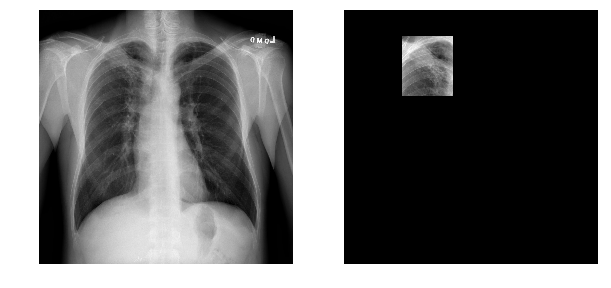

In [ ]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

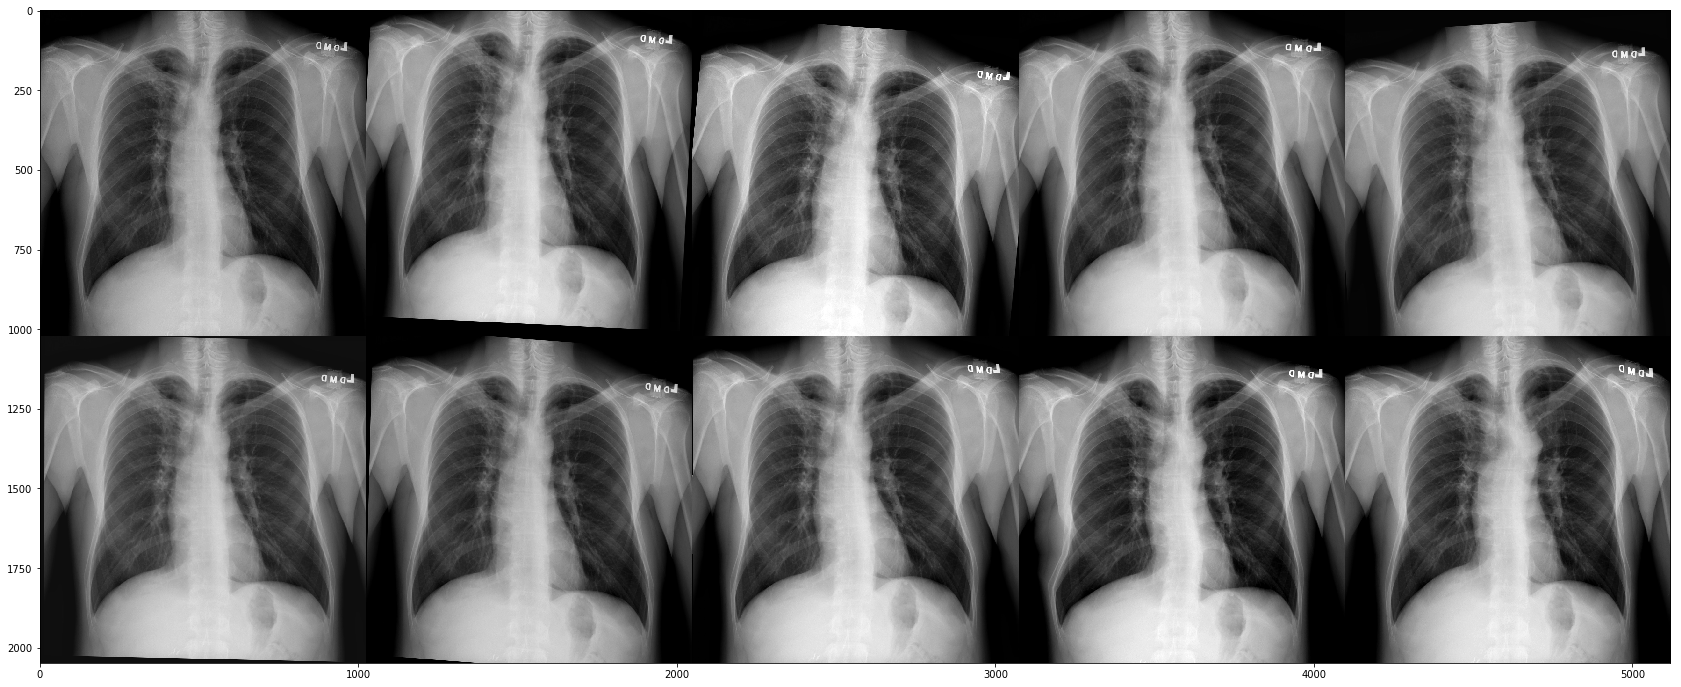

In [ ]:
# Image augmentation using the imgaug library

augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.04), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.03, 0.03), "y": (-0.05, 0.05)},
            rotate=(-5, 5),
            shear=(-3, 3),
        ),
        iaa.PiecewiseAffine(scale=(0.002, 0.03)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.85, 1.15)),
        iaa.ContrastNormalization((0.85, 1.15)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.12)),
        iaa.Sharpen(alpha=(0.0, 0.12)),
    ]),
])

# test augmentation on the same sample image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [ ]:
# training the mask RCNN model using the config specified previously

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

In [ ]:
NUM_EPOCHS = 16
LEARNING_RATE = 0.006

# Train Mask-RCNN Model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
# first epochs with higher lr to speedup the learning

model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='all',
            augmentation=None)


Starting at epoch 0. LR=0.012

Checkpoint Path: /kaggle/working/pneumonia20240622T0431/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [ ]:
# Including image augmentation to improve performance
# Reducing the learning rate to improve on performance

%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=NUM_EPOCHS,
            layers='all',
            augmentation=augmentation)


Starting at epoch 2. LR=0.006

Checkpoint Path: /kaggle/working/pneumonia20240622T0431/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

*The model ran for a total of 16 epochs with a final training loss of 1.53 and validation loss of 1.50. We see that the loss metric has sequentially reduced indicating that the model did a good job of learning from the training images dataset*

In [ ]:
# selecting the trained model

dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names:
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20240622T0431/mask_rcnn_pneumonia_0016.h5


In [ ]:
# Recreating the model in inference mode for making predictions
# Inference is performed on a single sample at a time

class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/pneumonia20240622T0431/mask_rcnn_pneumonia_0016.h5
Re-starting from epoch 16


In [ ]:
# setting the color for class 1

def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

**Model Evaluation**

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 



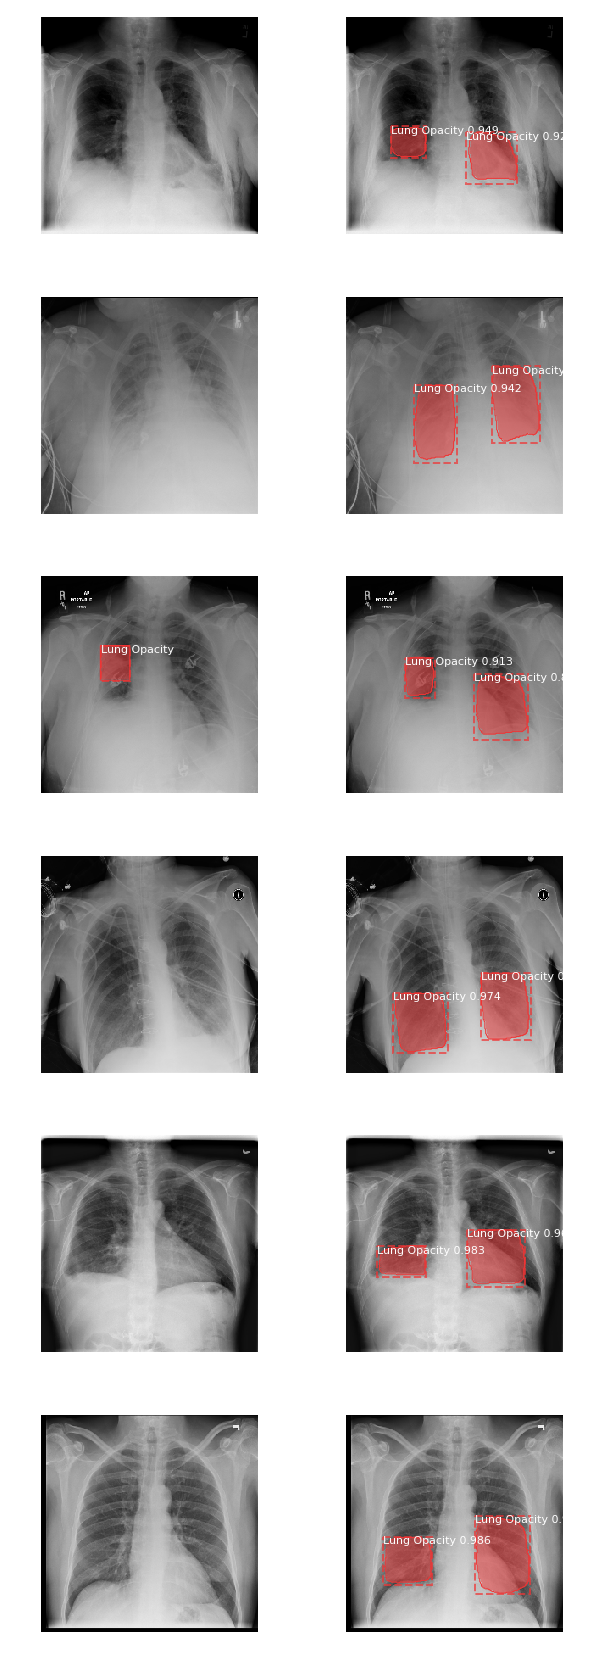

In [ ]:
# Visualising a few examples of ground truth vs. predictions
# on the validation dataset

dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):
    image_id = random.choice(dataset.image_ids)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])

    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'],
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])


*The model was able to identify correctly the lung opacity associated with Pneumonia in the third instance. However, there were a lot of false positives that were detected in the other instances.*

In [ ]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

c127904f-d321-4d79-b02d-599b73b0a734
[116  60 177 104]
x 240 y 464 h 176 w 244
[ 70 142 174 194]
x 568 y 280 h 208 w 416
[ 68  62 106  99]
x 248 y 272 h 148 w 152
13aad543-dcc2-4083-bcc6-60a2bfe5c9fb
[120  54 157 103]
x 216 y 480 h 196 w 148
[ 79 148 170 204]
x 592 y 316 h 224 w 364
265c655e-b97d-49b0-8b5c-83be37c0b80e
[ 88 150 178 213]
x 600 y 352 h 252 w 360
[178  60 223  99]
x 240 y 712 h 156 w 180
249b1047-ece4-490d-b903-5e457981986a
[109  58 162 114]
x 232 y 436 h 224 w 212
[120 149 179 203]
x 596 y 480 h 216 w 236


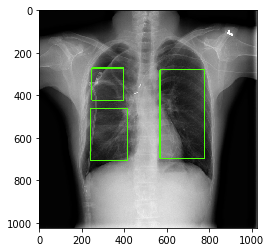

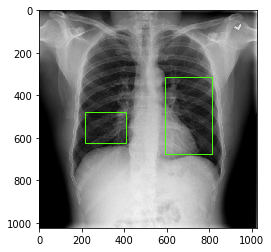

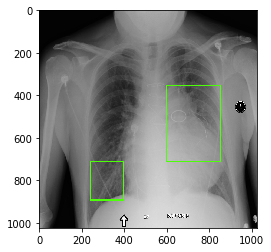

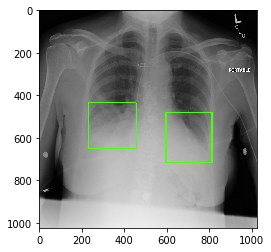

In [ ]:
# Visualising a few images from the test data directory and the
# the predicted bounding boxes for them

def visualize():
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)

    # original image
    image = ds.pixel_array

    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]

    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']:
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1
        height = y2 - y1
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure()
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

**Visual Inspection Summary:**

* The model seems to have successfully identified regions that visually appear to be pneumonia in instances 3 and 4.
* As previously noted, in instance 1 and 2, the model seems to have incorrectly identified regions as pneumonia. However, the visualized predictions might have to be corroborated by involving domain experts for further refinement of the model.


**Conclusion**

Achieving an 80% accuracy is significant, but continued efforts in model refinement are essential for achieving higher accuracy and reliability. The integration of Mask R-CNN with a ResNet-50 backbone could be a powerful approach for pneumonia detection in medical imaging. This comprehensive approach could contribute to more effective and accurate medical diagnoses.
